<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/Emojify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion detection from text using PyTorch and Federated Learning

For this project, we are going to implement an NLP task of creating a model to detect the emotion from text. We will develop this using the PyTorch library and the Federated Learning framework for decentralized training. 

We will create an emotion detection for the following 5 emotions:

| Emotion | Emoji   | Label   |
|------|------|------|
|Loving| ❤️| 0|
|Playful| ⚽️| 1|
|Happy| 😄| 2|
|Annoyed| 😞| 3|
|Foodie| 🍽| 4|

## Dataset

We will work with a dataset (X, Y) where we have:
*   X contains 132 sentences
*   Y contains a label between [0, 4] corresponding to the five emotions.

For example:

| Sentence | Emotion   |
|----------|-----------|
|food is life|  🍽 Foodie|
|I love you mum|  ❤️ Loving|
|Stop saying bullshit|  😞 Annoyed|
|congratulations on your acceptance|  😄 Happy|
|The assignment is too long|    😞 Annoyed|
|I want to go play| ⚽️ Playful|
|she did not answer my text| 😞 Annoyed|
|Your stupidity has no limit| 😞 Annoyed|
|how many points did he score|  ⚽️ Playful|
|my algorithm performs poorly| 😞 Annoyed|
|I got approved|  😄 Happy|

## The Model
We will build an LSTM model that takes as input word sequences that will take word ordering into account. We will use 50-dimensional [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained word embeddings to represent words. We will then feed those as an input into an LSTM that will predict the most appropiate emotion for the text. 

![alt text](https://drive.google.com/uc?id=1s-KYhU5JWF-jvAlZ2MIKKugxLLDdhpQP)


In [ ]:
!wget 'https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C5%20-%20Sequence%20Models/Week%202/Emojify/data/train_emoji.csv'
!wget 'https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C5%20-%20Sequence%20Models/Week%202/Emojify/data/test_emoji.csv'
!wget 'https://ia803006.us.archive.org/1/items/glove.6B.50d-300d/glove.6B.50d.txt'


--2022-09-08 22:23:11--  https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C5%20-%20Sequence%20Models/Week%202/Emojify/data/train_emoji.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3673 (3.6K) [text/plain]
Saving to: ‘train_emoji.csv.4’

train_emoji.csv.4   100%[===================>]   3.59K  --.-KB/s    in 0s      

2022-09-08 22:23:12 (61.5 MB/s) - ‘train_emoji.csv.4’ saved [3673/3673]

--2022-09-08 22:23:12--  https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C5%20-%20Sequence%20Models/Week%202/Emojify/data/test_emoji.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuser

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# HELPER FUNCTIONS

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def read_csv(filename):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [ ]:
X_train, Y_train = read_csv('/content/train_emoji.csv')
X_test, Y_test = read_csv('/content/test_emoji.csv')

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(132,) (132,)
(56,) (56,)


In [ ]:
print(X_train[0],Y_train[0])

never talk to me again 3


In [ ]:
print(np.eye(5)[0])
print(np.eye(5)[1])

[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]


In [ ]:
Y_oh_train = np.eye(5)[Y_train]
Y_oh_test = np.eye(5)[Y_test]
print(Y_oh_train.shape)
print(Y_oh_test.shape)

(132, 5)
(56, 5)


In [ ]:
data = open('/content/glove.6B.50d.txt', 'r')
next(iter(data))
#every line in data starts with a word then word's embedding


'the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581\n'

In [ ]:
with open('/content/glove.6B.50d.txt', 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line1 = line.strip().split()
            curr_word = line1[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line1[1:], dtype=np.float64)
            break


In [ ]:
words

{'the'}

In [ ]:
line1[:5]

['the', '0.418', '0.24968', '-0.41242', '0.1217']

word_to_index: dictionary mapping from words to their indices in the vocabulary
(400,001 words, with the valid indices ranging from 0 to 400,000)

index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary

word_to_vec_map: dictionary mapping words to their GloVe vector representation.

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/glove.6B.50d.txt')

### 2.2 Pytorch and mini-batching 

* In this exercise, we want to train pytorch using mini-batches. 
* However, most deep learning frameworks require that all sequences in the same mini-batch have the **same length**. 
    * This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.
    
#### Padding handles sequences of varying length
* The common solution to handling sequences of **different length** is to use padding.  Specifically:
    * Set a maximum sequence length
    * Pad all sequences to have the same length. 
    
##### Example of padding
* Given a maximum sequence length of 20, we could pad every sentence with "0"s so that each input sentence is of length 20. 
* Thus, the sentence "I love you" would be represented as $(e_{I}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. 
* In this example, any sentences longer than 20 words would have to be truncated. 
* One way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set. 


### 2.3 - The Embedding layer

* In Keras, the embedding matrix is represented as a "layer".
* The embedding matrix maps word indices to embedding vectors.
    * The word indices are positive integers.
    * The embedding vectors are dense vectors of fixed size.
    * When we say a vector is "dense", in this context, it means that most of the values are non-zero.  As a counter-example, a one-hot encoded vector is not "dense."
* The embedding matrix can be derived in two ways:
    * Training a model to derive the embeddings from scratch. 
    * Using a pretrained embedding
    
#### Using and updating pre-trained embeddings
* In this part, you will learn how to create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras
* You will initialize the Embedding layer with the GloVe 50-dimensional vectors. 
* In the code below, we'll show you how Keras allows you to either train or leave fixed this layer.  
* Because our training set is quite small, we will leave the GloVe embeddings fixed instead of updating them.



#### Inputs and outputs to the embedding layer

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer. 
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`. 

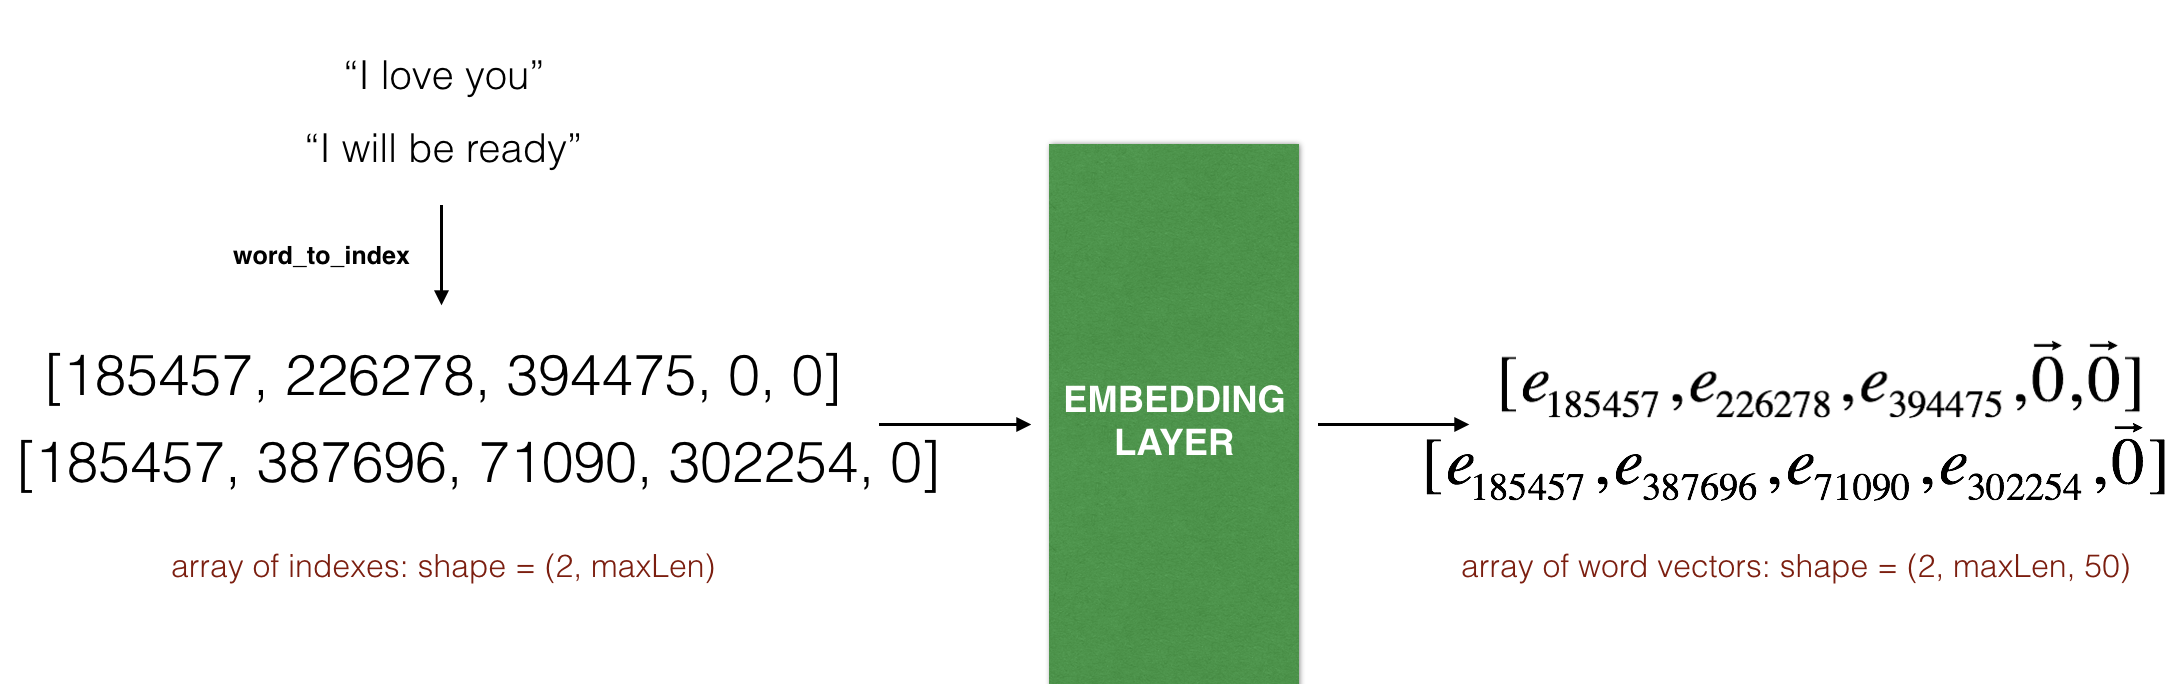
<caption><center> **Figure 4**: Embedding layer</center></caption>

#### Prepare the input sentences
**Exercise**: 
* Implement `sentences_to_indices`, which processes an array of sentences (X) and returns inputs to the embedding layer:
    * Convert each training sentences into a list of indices (the indices correspond to each word in the sentence)
    * Zero-pad all these lists so that their length is the length of the longest sentence.
    

In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]
    X_indices = np.zeros((m,max_len))

    for i in range(m):
      sentence = X[i]
      words = sentence.lower().split()
      for j,word in enumerate(words):
        index = word_to_index[word]
        X_indices[i][j] = index

    return X_indices


In [ ]:
X1 = np.array(["lol", "I love you", "this is very yummy"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['lol' 'I love you' 'this is very yummy']
X1_indices = [[225122.      0.      0.      0.      0.]
 [185457. 226278. 394475.      0.      0.]
 [358160. 192973. 377946. 394957.      0.]]


#### Build embedding layer

* Let's build the `Embedding()` layer, using pre-trained word vectors. 
* The embedding layer takes as input a list of word indices.
    * `sentences_to_indices()` creates these word indices.
* The embedding layer will return the word embeddings for a sentence. 

**Exercise**: Implement `pretrained_embedding_layer()` with these steps:
1. Initialize the embedding matrix as a numpy array of zeros.
    * The embedding matrix has a row for each unique word in the vocabulary.
        * **There is one additional row to handle "unknown" words**.
        * So vocab_len is the number of unique words plus one.
    * Each row will store the vector representation of one word. 
        * For example, one row may be 50 positions long if using GloVe word vectors.
    * In the code below, `emb_dim` represents the length of a word embedding.
2. Fill in each row of the embedding matrix with the vector representation of a word
    * Each word in `word_to_index` is a string.
    * word_to_vec_map is a dictionary where the keys are strings and the values are the word vectors.
3. Define the Keras embedding layer. 
    * Use [Embedding()](https://keras.io/layers/embeddings/). 
    * The input dimension is equal to the vocabulary length (number of unique words plus one).
    * The output dimension is equal to the number of positions in a word embedding.
    * Make this layer's embeddings fixed.
        * **If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings**.
        * **In this case, we don't want the model to modify the word embeddings**.
4. Set the embedding weights to be equal to the embedding matrix.
    * Note that this is part of the code is already completed for you and does not need to be modified. 

first we make a matrix named weights_matrix which every row (weights_matrix[i]) has the embedding of a word [embedding matrix(E) we learned in the course]

then for looking up for a word , instead of this (E.o = e) which is expensive, we use function nn.Embedding , we give an index to this and it gives embedding of a word with that index

```
# FloatTensor containing pretrained weights
weight = torch.FloatTensor([[1, 2.3, 3], [4, 5.1, 6.3]])
embedding = nn.Embedding.from_pretrained(weight)
Get embeddings for index 1
input = torch.LongTensor([1])
embedding(input)
tensor([[ 4.0000,  5.1000,  6.3000]])
```
pretrained because we use Glove Embedding not learning by itself from scrach and random values

In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True):
    num_embeddings = len(word_to_index) + 1                   
    embedding_dim = word_to_vec_map["cucumber"].shape[0]  #  dimensionality of GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (num_embeddings, embedding_dim)
    weights_matrix = np.zeros((num_embeddings, embedding_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        weights_matrix[index, :] = word_to_vec_map[word]  #weights_matrix[index, :]==weights_matrix[index]

    embed = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).type(torch.FloatTensor), freeze=non_trainable)

    return embed, num_embeddings, embedding_dim


In [ ]:
for word, index in word_to_index.items():
  print(word,index)
  break

! 1


In [ ]:
X1 = np.array(["I love you", "this is very yummy"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
X1_indices = torch.tensor(X1_indices,dtype=torch.long)
print("X1_indices =", X1_indices)
embed,_,_ = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)
embed(X1_indices).shape

X1_indices = tensor([[185457, 226278, 394475,      0,      0],
        [358160, 192973, 377946, 394957,      0]])


torch.Size([2, 5, 50])

In [ ]:
embed.weight  # weight_matrix

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5840,  0.3903,  0.6528,  ..., -1.2338,  0.4672,  0.7886],
        [-1.0588,  0.2695,  0.9463,  ...,  0.3114,  0.7984,  0.2039],
        ...,
        [ 0.3230,  0.3230, -0.3136,  ...,  1.8267, -0.4305, -1.1958],
        [ 0.3871,  0.0984, -0.7386,  ...,  1.0611, -0.2125, -0.6551],
        [-0.0198, -0.0401,  0.8689,  ...,  0.2371, -0.1819,  0.2477]])

## Defining the Network using Pretrained Embedding Layer using GloVe Word Embeddings

 **LTSM**
Parameters:

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers

**Inputs: input, (h_0, c_0):**

input = (N,L,H_in)

h_0 = c_0 = (num_layers,N,H_out)


**Outputs: output, (h_n, c_n)**

output = (N,L,H_out)

**N**:batch_size  ,,  **L**:sequence_length  ,, **H_in**:input_size ,, **H_out**:hidden_size 


In [ ]:
# input_size = embedding_dim =  dimensionality of GloVe word vectors (= 50)

class NN(nn.Module):
  def __init__(self, embedding, embedding_dim, hidden_dim, vocab_size, output_dim, batch_size): # embedding_dim = input_size
      super().__init__()

      self.batch_size = batch_size

      self.hidden_dim = hidden_dim

      self.word_embeddings = embedding

      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=2,
                          dropout = 0.5,
                          batch_first = True)

      # The linear layer that maps from hidden state space to output space
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, sentence):
      
      #sentence = sentence.type(torch.LongTensor)
      #print ('Shape of sentence is:', sentence.shape)

      sentence = sentence.to(device)

      embeds = self.word_embeddings(sentence)
      #print ('Embedding layer output shape', embeds.shape)

      # initializing the hidden state to 0
      #hidden=None
      
      h0 = torch.zeros(2,sentence.size(0),self.hidden_dim,requires_grad=True,device=device)
      c0 = torch.zeros(2,sentence.size(0),self.hidden_dim,requires_grad=True,device=device)
      
      lstm_out, h = self.lstm(embeds, (h0, c0))
      # get info from last timestep only
      lstm_out = lstm_out[:, -1, :]
      #print ('LSTM layer output shape', lstm_out.shape)
      #print ('LSTM layer output ', lstm_out)

      # Dropout
      lstm_out = torch.dropout(lstm_out, 0.5,train=True)
      fc_out = self.fc(lstm_out)
      #print ('FC layer output shape', fc_out.shape)
      #print ('FC layer output ', fc_out)
      
      out = fc_out
      out = torch.softmax(out, dim=1)
      #print ('Output layer output shape', out.shape)
      #print ('Output layer output ', out)
      return out
  

In [ ]:
maxLen = len(max(X_train, key=len).split())
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)

embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True)

hidden_dim=128
output_size=5
batch_size = 32

model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
epochs = 50

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_indices, dtype=torch.long), torch.tensor(Y_train_oh, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_indices, dtype=torch.long), torch.tensor(Y_test_oh, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size,)


In [ ]:
def train(model, trainloader, criterion, optimizer, epochs=10):
  running_loss = 0
  train_losses, test_losses, accuracies = [], [], []

  for epoch in range(epochs):
    model.train()

    for sentences,labels in train_loader:
      sentences, labels = sentences.to(device), labels.float().to(device)
      torch.long
      optimizer.zero_grad()
      y_pred = model(sentences)
      loss = criterion(y_pred,labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()

    else:
      model.eval()
      test_loss = 0
      accuracy = 0

      with torch.no_grad():
        for sentences,labels in test_loader:
          sentences,labels = sentences.to(device), labels.float().to(device)
          log_pred = model(sentences)
          test_loss += criterion(log_pred,labels).cpu()

          top_p, top_class = log_pred.topk(1, dim=1)  #top_class.shape=(32,1) & labels.shape=(32,5)
          _ , indices = torch.topk(labels,k=1,dim=1)
          acc = (top_class == indices).cpu()
          print(torch.mean(acc.type(torch.float)))
          accuracy += torch.mean(acc.type(torch.float))

          train_loss = (running_loss/len(train_loader))
          test_loss = (test_loss/len(test_loader))
          accuracy = (accuracy / len(test_loader) * 100)
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          accuracies.append(accuracy)

          print(f'Epoch: {epoch+1}/{epochs} .. Training Loss: {running_loss/len(train_loader):.3f} ..Test Loss: {test_loss/len(test_loader):.3f}..Test Accuracy: {accuracy/len(test_loader):.3f} ')

  # Plot
  plt.figure(figsize=(20, 5))
  plt.plot(train_losses, c='b', label='Training loss')
  plt.plot(test_losses, c='r', label='Testing loss')
  plt.xticks(np.arange(0, epochs))
  plt.title('Losses')
  plt.legend(loc='upper right')
  plt.show()
  plt.figure(figsize=(20, 5))
  plt.plot(accuracies)
  plt.xticks(np.arange(0, epochs))
  plt.title('Accuracy')
  plt.show()



tensor(0.2500)
Epoch: 1/50 .. Training Loss: 1.606 ..Test Loss: 0.400..Test Accuracy: 6.250 
tensor(0.4167)
Epoch: 1/50 .. Training Loss: 1.606 ..Test Loss: 0.596..Test Accuracy: 322.917 
tensor(0.2500)
Epoch: 2/50 .. Training Loss: 3.190 ..Test Loss: 0.393..Test Accuracy: 6.250 
tensor(0.2083)
Epoch: 2/50 .. Training Loss: 3.190 ..Test Loss: 0.583..Test Accuracy: 317.708 
tensor(0.2500)
Epoch: 3/50 .. Training Loss: 4.758 ..Test Loss: 0.393..Test Accuracy: 6.250 
tensor(0.2500)
Epoch: 3/50 .. Training Loss: 4.758 ..Test Loss: 0.578..Test Accuracy: 318.750 
tensor(0.3125)
Epoch: 4/50 .. Training Loss: 6.305 ..Test Loss: 0.389..Test Accuracy: 7.812 
tensor(0.2917)
Epoch: 4/50 .. Training Loss: 6.305 ..Test Loss: 0.577..Test Accuracy: 397.917 
tensor(0.3125)
Epoch: 5/50 .. Training Loss: 7.813 ..Test Loss: 0.392..Test Accuracy: 7.812 
tensor(0.5000)
Epoch: 5/50 .. Training Loss: 7.813 ..Test Loss: 0.553..Test Accuracy: 403.125 
tensor(0.2812)
Epoch: 6/50 .. Training Loss: 9.294 ..Test Lo

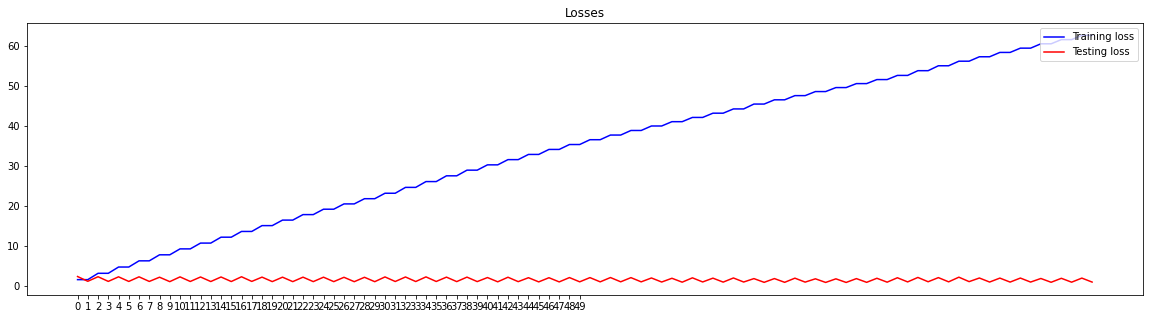

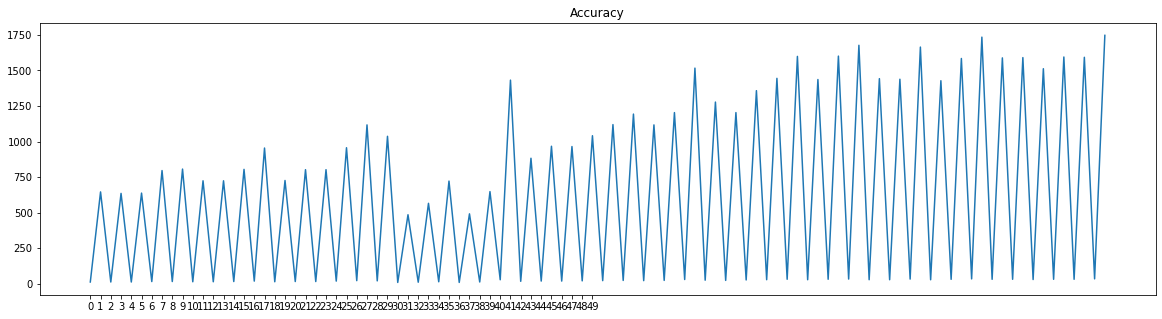

In [ ]:
train(model, train_loader, criterion, optimizer, epochs)

In [ ]:
sentences,labels = next(iter(train_loader))

In [ ]:
labels.shape

torch.Size([32, 5])

In [ ]:
labels

tensor([[0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]])

In [ ]:
a = torch.tensor([[2],
        [2],
        [2],
        [3],
        [3],
        [2],
        [2],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [2],
        [3],
        [2],
        [3],
        [3],
        [2],
        [2],
        [2],
        [2],
        [2],
        [3],
        [2],
        [3],
        [2],
        [3],
        [2],
        [2],
        [3],
        [3]])

In [ ]:
a.shape

torch.Size([32, 1])

In [ ]:
_ , indices = torch.topk(labels,k=1,dim=1)

In [ ]:
sum(a==indices)

tensor([10])